In [1]:
using Utils, Plots, LinearAlgebra
using DifferentialEquations
include("./Rocket_Acceleration.jl")
include("./Quaternions.jl")


(process:25252): GLib-GIO-WARNING **: 22:54:43.730: Unexpectedly, UWP app `61252GDSoftware.EasyPosterPrinter_8.0.0.0_neutral__8gw22ntmsa2nc' (AUMId `61252GDSoftware.EasyPosterPrinter_8gw22ntmsa2nc!App') supports 1 extensions but has no verbs


to_matrix (generic function with 1 method)

In [11]:
module scp_new_problem
include("./6dof fixed t_burn udotdot.jl")
end # module

using .scp_new_problem

In [3]:
solution = scp_new_problem.solve(:ptr); # Remember J is augmented cost function

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | ALMOST_O | 1e-01 | 0e+00 | 2e-08 | 9.27e+00  |           | 8e-02 | 4e-01 | 2e-01 | 2e-01 | T   | 0.74  | 0.48  | 0.16 


2  | ALMOST_O | 4e-04 | 0e+00 | 7e-09 | 3.58e-01  | 96.14     | 1e-02 | 3e-01 | 3e-02 | 4e-02 | T   | 0.06  | 0.28  | 0.03 


3  | ALMOST_O | 4e-04 | 0e+00 | 4e-09 | 2.81e-01  | 21.51     | 7e-03 | 3e-01 | 7e-04 | 8e-03 | T   | 0.02  | 0.27  | 0.00 


4  | ALMOST_O | 9e-06 | 0e+00 | 4e-08 | 2.79e-01  | 0.63      | 2e-03 | 2e-01 | 4e-05 | 2e-03 | T   | 0.07  | 0.17  | 0.00 


5  | ALMOST_O | 1e-05 | 0e+00 | 2e-08 | 2.87e-01  | -2.75     | 2e-03 | 3e-01 | 4e-05 | 2e-03 | T   | 0.83  | 0.30  | 0.00 


6  | ALMOST_O | 6e-07 | 0e+00 | 2e-09 | 2.78e-01  | 2.99      | 3e-04 | 4e-02 | 8e-06 | 3e-04 | T   | 0.04  | 0.04  | 0.00 


7  | ALMOST_O | 3e-07 | 0e+00 | 1e-09 | 2.78e-01  | 0.09      | 6e-05 | 1e-02 | 2e-06 | 6e-05 | T   | 0.02  | 0.01  | 0.00 

In [13]:
scp_new_problem.print(solution)
scp_new_problem.plot(solution)
# scp_new_problem.save(solution)

# Increase N if deviating too far from 1.0

Coast time (s): 1.3244667977727518
Impact Velocity Magnitude (m/s): 0.5271272974727045
True Impact Velocity Magnitude (m/s): 0.5268102851832746


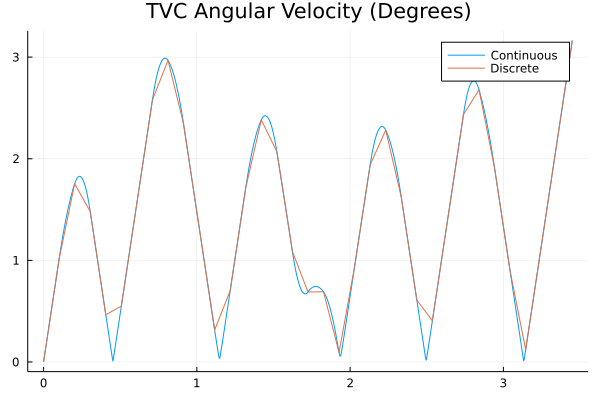

In [64]:
t_burn = 3.45

t_plot = LinRange(0, 1, 1000) * t_burn
Plots.plot(t_plot, [rad2deg(norm(sample(solution.xc, k)[17:19])) for k in t_plot / t_burn], title="TVC Angular Velocity (Degrees)", label = "Continuous")

t_plot = solution.td * t_burn
Plots.plot!(t_plot, rad2deg.(norm.(eachcol(solution.xd[17:19, :]))), label = "Discrete")

In [65]:
count(abs.(norm.(eachcol(solution.xd[7:10, :]))) .- 1 .> 1e-6) # check if quat norm is within 1e-6 of 1.

0

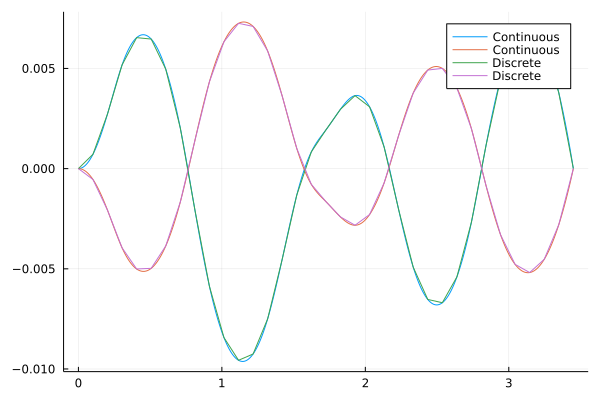

In [66]:
t_plot = LinRange(0, 1, 1000) * t_burn
Plots.plot(t_plot, reduce(hcat, [sample(solution.xc, k)[14:15] for k in t_plot / t_burn])', label = "Continuous")

t_plot = solution.td * t_burn
Plots.plot!(t_plot, solution.xd[14:15, :]', label = "Discrete")

3.4503430879647743


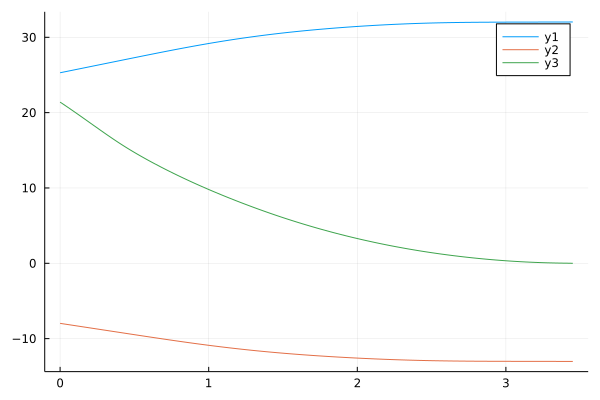

In [67]:
t_burn = 3.45
g = [0; 0; -9.80655]

Id = Diagonal([0.0826975856, 0.0826975856, 2.4778e-04])

function f!(dx, x, p, t)
    t_burn = 3.45

    r = x[1:3]
    v = x[4:6]
    quat = x[7:10]
    w = x[11:13]
    T = x[14:16]
    T_dot = x[17:19]

    Control = sample(solution.uc, t / t_burn) # if false, false

    dx[1:3] = v
    dx[4:6] = g + rotate(quat, T) * Acceleration(t)
    dx[7:10] = 1/2 * quatL(quat) * [0; w]
    dx[11:13] = Id \ ([0; 0; -0.4] × T * Thrust(t) + [0; 0; Control[4]] - cross(w, Id * w))
    dx[14:16] = T_dot
    dx[17:19] = Control[1:3]
end

prob = ODEProblem(f!, solution.xd[:, 1], (0.0, t_burn + 1.0))

condition(x,t,integrator) = x[3] # when zero halt integration
affect!(integrator) = terminate!(integrator)
cb = ContinuousCallback(condition,affect!)

sol = DifferentialEquations.solve(prob, reltol=1e-8, abstol=1e-8, callback=cb)

# xc = sol(solution.td * t_burn).u
# xmatrix = transpose(reduce(hcat, xc))

# println(norm(xmatrix[end, 4:6]))

# Plots.plot(xmatrix[:, 1], xmatrix[:, 2], xmatrix[:, 3])

println(sol.t[end])
Plots.plot(sol.t, reduce(hcat, sol.u)[1:3, :]')

In [68]:
# Thrustfine = reduce(hcat, sol.u)[14:16, 1:end - 1]
# rollfine = [sample(solution.uc, t)[4] for t in sol.t[1:end - 1]]
# using DelimitedFiles
# writedlm("u.csv", hcat([0; solution.p[1] - 1e-10; solution.p[1] .+ sol.t[1:end - 1]], [[0 0 1 0]; [0 0 1 0]; [Thrustfine' rollfine] ]), ',')